# Settings & Data Loading

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import os

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None

np.random.seed(10)

In [ ]:
# data loading
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'charges'}>, <AxesSubplot:>]],
      dtype=object)

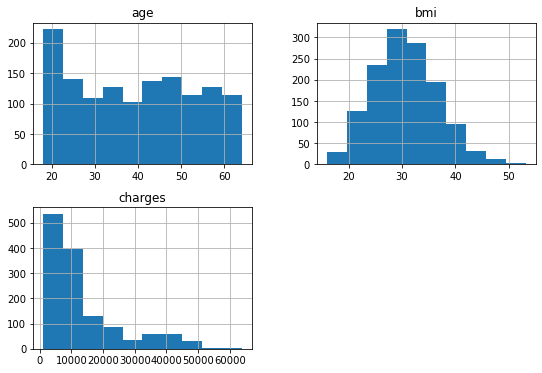

In [ ]:
df[['age','bmi','charges']].hist(figsize=(9,6))
# charges close to exponential distribution

<AxesSubplot:>

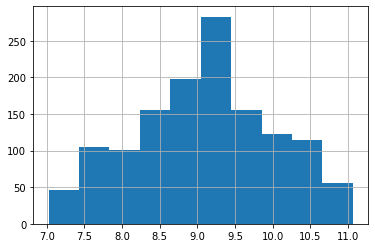

In [ ]:
# take the log of 'charges' to make it closer to normal distribution
np.log(df['charges']).hist(figsize=(6,4))

In [ ]:
df['sex'].value_counts()
# almost equal sizes of male and female

male      676
female    662
Name: sex, dtype: int64

In [ ]:
df['children'].value_counts()
# imbalanced values in children
# we can merge the last three values together

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [ ]:
df['smoker'].value_counts()
# imbalanced values in smoker

no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
df['region'].value_counts()
# almost equal size in each region

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

<AxesSubplot:>

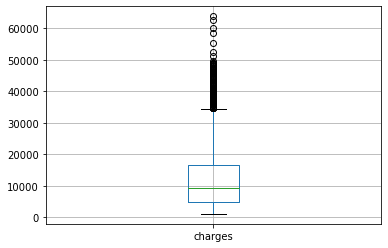

In [ ]:
df.boxplot(column="charges")

In [ ]:
# map categorical features into numerical data for more direct observations
df1 = df.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df1['region'] = le.fit_transform(df1['region'])
df1['sex']=df1['sex'].apply(lambda x: 1 if x=='male' else 0)
df1['smoker']=df1['smoker'].apply(lambda x: 1 if x=='yes' else 0)

In [ ]:
# see the correlation among different features and the target value
df1.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


Smoker and age have stronger correlations with charges

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='sex', ylabel='age'>,
        <AxesSubplot:xlabel='bmi', ylabel='age'>,
        <AxesSubplot:xlabel='children', ylabel='age'>,
        <AxesSubplot:xlabel='smoker', ylabel='age'>,
        <AxesSubplot:xlabel='region', ylabel='age'>,
        <AxesSubplot:xlabel='charges', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='sex'>,
        <AxesSubplot:xlabel='sex', ylabel='sex'>,
        <AxesSubplot:xlabel='bmi', ylabel='sex'>,
        <AxesSubplot:xlabel='children', ylabel='sex'>,
        <AxesSubplot:xlabel='smoker', ylabel='sex'>,
        <AxesSubplot:xlabel='region', ylabel='sex'>,
        <AxesSubplot:xlabel='charges', ylabel='sex'>],
       [<AxesSubplot:xlabel='age', ylabel='bmi'>,
        <AxesSubplot:xlabel='sex', ylabel='bmi'>,
        <AxesSubplot:xlabel='bmi', ylabel='bmi'>,
        <AxesSubplot:xlabel='children', ylabel='bmi'>,
        <AxesSubplot:xlabel='smoker', ylabel='bmi'>,
        <A

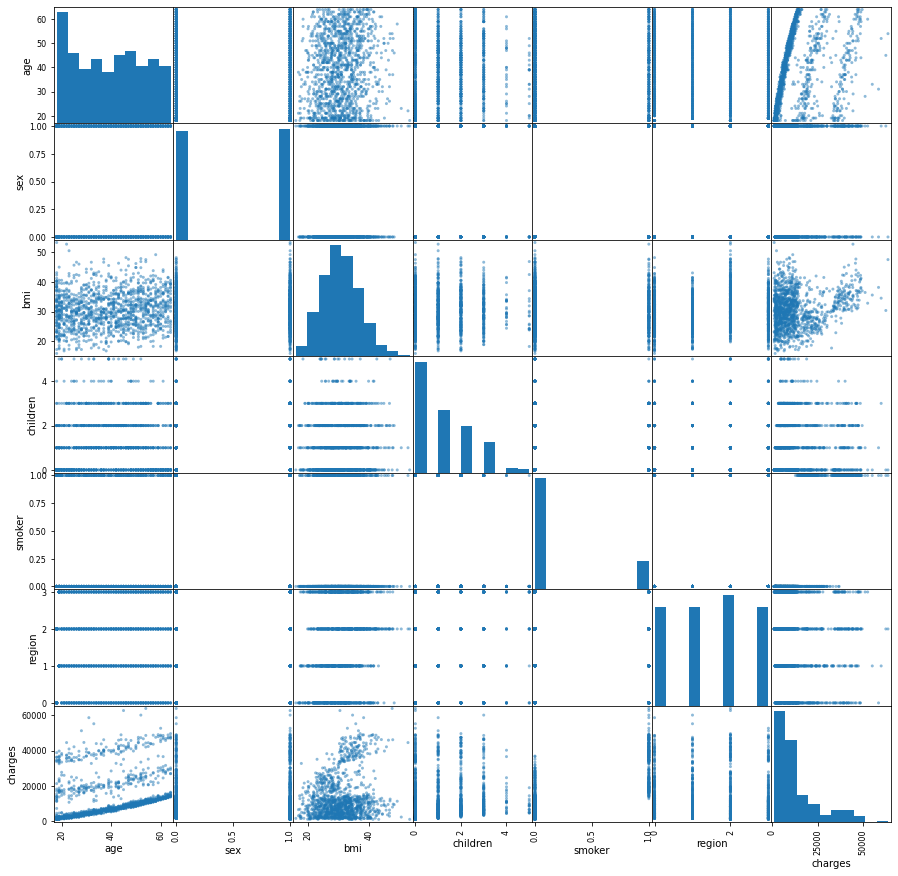

In [ ]:
# draw a scatter matrix to observe the relationship
from pandas.plotting import scatter_matrix
scatter_matrix(df1, figsize=(15, 15))

'Age' seems to have a linear relationship with 'charges'.   
But it can be divided into three lines with obvious boundaries. I think it is related to other features.

Text(0.5, 1.0, 'smoker')

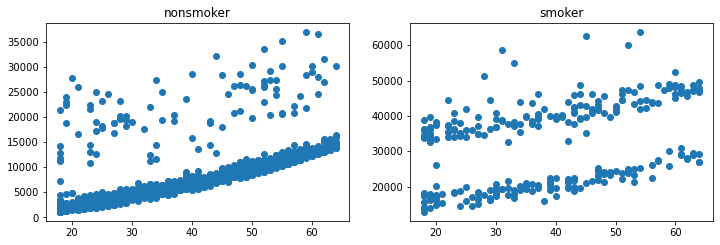

In [ ]:
# decompose the relationship between age and charges by classifying the samples into smoker and non-smoker
df_nonsmoker=df1[df1['smoker']==0]
df_smoker=df1[df1['smoker']==1]
del df_nonsmoker['smoker'], df_smoker['smoker']
fig=plt.figure(figsize=(25,8))
plt.subplot(241)
plt.scatter(df_nonsmoker['age'], df_nonsmoker['charges'])
plt.title('nonsmoker')
plt.subplot(242)
plt.scatter(df_smoker['age'], df_smoker['charges'])
plt.title('smoker')

There is an obvious boundary in the smoker graph.

In [ ]:
df_smoker.corr()

,age,sex,bmi,children,region,charges
age,1.000000,-0.005758,0.059674,0.081183,-0.036548,0.368224
sex,-0.005758,1.000000,0.148350,0.076907,0.066943,0.101226
bmi,0.059674,0.148350,1.000000,-0.012619,0.212198,0.806481
children,0.081183,0.076907,-0.012619,1.000000,0.015126,0.035945
region,-0.036548,0.066943,0.212198,0.015126,1.000000,0.128983
charges,0.368224,0.101226,0.806481,0.035945,0.128983,1.000000


bmi has the largest correlation with charges in the smoker group.

Text(0, 0.5, 'charges')

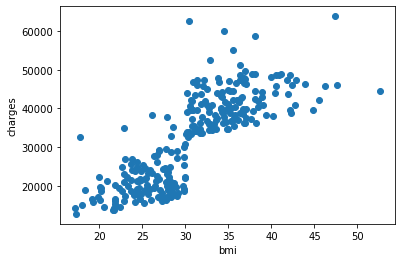

In [ ]:
plt.scatter(df_smoker['bmi'], df_smoker['charges'])
plt.xlabel('bmi')
plt.ylabel('charges')

The graph shows that the data can be divided into two groups by certain value of bmi which is around 3.   
Let's find the boundary value more accurately.

In [ ]:
# use kmeans to divide the data into two groups
x=df_smoker[['bmi','charges']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x=scaler.fit_transform(x)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

KMeans(n_clusters=2)

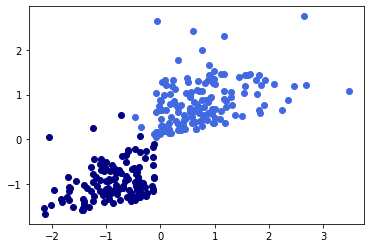

In [ ]:
labels = kmeans.labels_
color=['royalblue','navy']
for c in range(2):
    cluster=x[labels==c]
    plt.scatter(cluster[:,0], cluster[:,1], color=color[c])

In [ ]:
low_bmi_group=x[labels==1]
low_bmi_group=scaler.inverse_transform(low_bmi_group)
low_bmi_group=pd.DataFrame(low_bmi_group)
low_bmi_group.columns=['bmi','charges']
low_bmi_group.sort_values('bmi',inplace=True)
bmi_boundary=low_bmi_group.iloc[-1,0]
bmi_boundary

30.0

bmi=30 is considered as the boundary value

Text(0.5, 1.0, 'bmi>30')

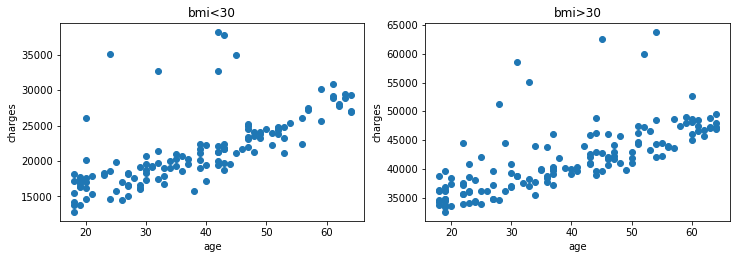

In [ ]:
# decompose the relationship between age and charges again
df_lowbmi=df_smoker[df_smoker['bmi']<=bmi_boundary]
df_highbmi=df_smoker[df_smoker['bmi']>bmi_boundary]
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.scatter(df_lowbmi['age'],df_lowbmi['charges'])
plt.xlabel('age')
plt.ylabel('charges')
plt.title('bmi<30')
plt.subplot(222)
plt.scatter(df_highbmi['age'],df_highbmi['charges'])
plt.xlabel('age')
plt.ylabel('charges')
plt.title('bmi>30')

In the two groups respectively, charges seem to be linearly related to age.

# Data Preprocessing

In [ ]:
df.isnull().sum()
# no missing values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
# group children larger than or equal to 2 together
df['children'] = df['children'].apply(lambda x: 2 if x>=2 else x)
df['children'].value_counts()

0    574
2    440
1    324
Name: children, dtype: int64

In [ ]:
df['smoker_bmi'] = df['smoker'].apply(lambda x: 1 if x=='yes' else 0)*df['bmi']
df['smoker_bmi>30'] = df['smoker_bmi'].apply(lambda x: 1 if x>30 else 0)

In [ ]:
# one hot encoding
df = pd.concat([df, pd.get_dummies(df[['sex','smoker','region']])], axis=1)
del df['sex'], df['smoker'], df['region']

In [ ]:
# take the log of charges
df['charges'] = np.log(df['charges'])

In [ ]:
# split the dataset into train set and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.copy().drop('charges', axis=1)
Y_train = train_set['charges']
X_test = test_set.copy().drop('charges', axis=1)
Y_test = test_set['charges']

In [ ]:
# standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building the models

# 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(Y_test, pred)
lin_rmse = np.sqrt(lin_mse)
lin_r2 = r2_score(Y_test, pred)
print('lin_rmse=', lin_rmse)
print('lin_r2=', lin_r2)

lin_rmse= 0.4581527957755446
lin_r2= 0.7401890443356658


For linear regression, r2 = 0.740 on test set.

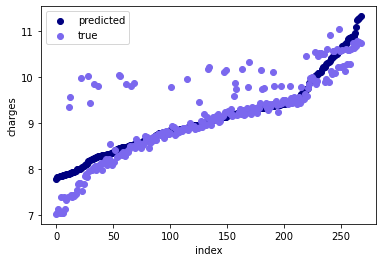

In [ ]:
# do some visualizations on the prediction results
def result_visualization(pred, Y_test):
    result=pd.DataFrame([pred, Y_test]).T
    result.columns=['predicted','true']
    result.sort_values('predicted', ascending=True, inplace=True)
    result.reset_index(drop=True, inplace=True)
    plt.scatter(result.index, result['predicted'], label='predicted', color='navy')
    plt.scatter(result.index, result['true'], label='true', color='mediumslateblue')
    plt.xlabel('index')
    plt.ylabel('charges')
    plt.legend()
    plt.show()

result_visualization(pred, Y_test)

Linear regression tends to under predict the charges value.

In [ ]:
# do some analysis about the residuals
x_test = scaler.inverse_transform(X_test)
X = pd.concat([pd.DataFrame(x_test), Y_test.reset_index(drop=True), pd.DataFrame(pred)], axis=1)
X.columns = list(df.columns.drop('charges')) + ['charges', 'predicted charges']
X['residuals'] = X['predicted charges'] - X['charges']
big_res = X[abs(X['residuals'])>1]
del big_res['smoker_bmi'], big_res['smoker_bmi>30'], big_res['smoker_no'], big_res['smoker_yes']
big_res['children'] = big_res['children'].apply(lambda x: 0 if x<0 else x)
big_res['region_northeast'] = big_res['region_northeast'].apply(lambda x: 0 if x<0 else x)
big_res['region_southwest'] = big_res['region_southwest'].apply(lambda x: 0 if x<0 else x)
big_res.sort_values('residuals')
big_res.describe()

<ipython-input-609-5b1ba9884a65>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_res['children'] = big_res['children'].apply(lambda x: 0 if x<0 else x)
<ipython-input-609-5b1ba9884a65>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_res['region_northeast'] = big_res['region_northeast'].apply(lambda x: 0 if x<0 else x)
<ipython-input-609-5b1ba9884a65>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,charges,predicted charges,residuals
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,30.705882,29.350000,1.058824,0.529412,0.470588,0.294118,0.352941,0.235294,0.117647,9.906791,8.501699,-1.405092
std,13.118521,3.906942,0.899346,0.514496,0.514496,0.469668,0.492592,0.437237,0.332106,0.265676,0.429943,0.276659
min,18.000000,24.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.348591,7.900481,-1.944699
25%,19.000000,26.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.810174,8.201196,-1.602663
50%,25.000000,29.600000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.963273,8.448360,-1.361466
75%,47.000000,32.230000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,10.053694,8.887708,-1.170167
max,53.000000,38.280000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.318396,9.245889,-1.014498


Compared to the entire dataset, those samples that are significantly under-evaluate have smaller ages and averagely have larger numbers of children.

In [ ]:
'''
pip install imbalanced-learn==0.6.2
y=train_set['smoker_yes']
x=train_set.drop(['smoker_no', 'smoker_yes'], axis=1)
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=10, k_neighbors=5)
new_x, new_y = smo.fit_sample(x, y)
new_x=pd.DataFrame(new_x)
new_y=pd.DataFrame(new_y)
new_x.insert(loc=8, column='smoker_yes', value=new_y)
new_x.insert(loc=8, column='smoker_no', value=new_y['smoker_yes'].apply(lambda x: 1 if x==0 else 0))
Y_train=new_x['charges']
X_train=new_x.drop('charges', axis=1)
'''

# 2. KNN Regression

In [ ]:
# search for the best n_neighbors using grid search
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
knn_grid = GridSearchCV(estimator=KNeighborsRegressor(), param_grid={'n_neighbors':np.arange(1,20)},cv=5)
knn_grid.fit(X_train, Y_train)
knn_grid.best_params_['n_neighbors']

12

In [ ]:
knn = KNeighborsRegressor(n_neighbors=knn_grid.best_params_["n_neighbors"])
knn.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=12)

In [ ]:
pred = knn.predict(X_test)
knn_mse = mean_squared_error(Y_test, pred)
knn_rmse = np.sqrt(knn_mse)
knn_r2 = r2_score(Y_test, pred)
print('knn_rmse=', knn_rmse)
print('knn_r2=', knn_r2)

knn_rmse= 0.41967084871248234
knn_r2= 0.7820010586649748


For KNN regression, r2 = 0.782 on test set.

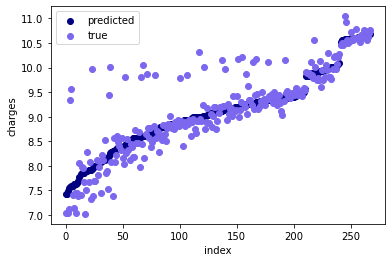

In [ ]:
result_visualization(pred, Y_test)

# 3. Lasso Regression

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
lasso = LassoCV(alphas=np.logspace(-3,3,500), cv=3)
lasso.fit(X_train, Y_train)

LassoCV(alphas=array([1.00000000e-03, 1.02807322e-03, 1.05693455e-03, 1.08660611e-03,
       1.11711065e-03, 1.14847155e-03, 1.18071285e-03, 1.21385926e-03,
       1.24793621e-03, 1.28296980e-03, 1.31898690e-03, 1.35601511e-03,
       1.39408283e-03, 1.43321923e-03, 1.47345431e-03, 1.51481892e-03,
       1.55734477e-03, 1.60106446e-03, 1.64601150e-03, 1.69222035e-03,
       1.73972643e-03, 1.78856616e-0...
       5.28989308e+02, 5.43839743e+02, 5.59107078e+02, 5.74803016e+02,
       5.90939590e+02, 6.07529169e+02, 6.24584471e+02, 6.42118571e+02,
       6.60144909e+02, 6.78677305e+02, 6.97729965e+02, 7.17317494e+02,
       7.37454909e+02, 7.58157646e+02, 7.79441575e+02, 8.01323013e+02,
       8.23818733e+02, 8.46945981e+02, 8.70722485e+02, 8.95166472e+02,
       9.20296681e+02, 9.46132376e+02, 9.72693362e+02, 1.00000000e+03]),
        cv=3)

In [ ]:
pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(Y_test, pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(Y_test, pred)
print('lasso_rmse=', lasso_rmse)
print('lasso_r2=', lasso_r2)

lasso_rmse= 0.45877842784942163
lasso_r2= 0.7394789884278148


For Lasso regression, r2=0.739 on test set.

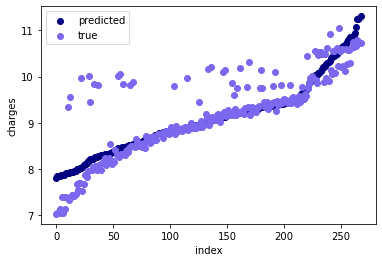

In [ ]:
result_visualization(pred, Y_test)

# 4. Decision Tree Regression

In [ ]:
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df = pd.concat([df, pd.get_dummies(df[['sex','smoker','region']])], axis=1)
del df['sex'], df['smoker'], df['region']
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)
X_train = train_set.copy().drop('charges', axis=1)
Y_train = train_set['charges']
X_test = test_set.copy().drop('charges', axis=1)
Y_test = test_set['charges']

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=10)
tree_reg.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=10)

In [ ]:
pred = tree_reg.predict(X_test)
tree_mse = mean_squared_error(Y_test, pred)
tree_rmse = np.sqrt(tree_mse)
tree_r2 = r2_score(Y_test, pred)
print('tree_rmse=', tree_rmse)
print('tree_r2=', tree_r2)

tree_rmse= 6488.270117432817
tree_r2= 0.6998400023289894


For Decision tree regression, r2=0.70 on test set.

# 5. Random Forest Regression

In [ ]:
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df['children'] = df['children'].apply(lambda x: 2 if x>=2 else x)
df['children'].value_counts()
df = pd.concat([df, pd.get_dummies(df[['sex','smoker','region']])], axis=1)
del df['sex'], df['smoker'], df['region']
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)
X_train = train_set.copy().drop('charges', axis=1)
Y_train = train_set['charges']
X_test = test_set.copy().drop('charges', axis=1)
Y_test = test_set['charges']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = RandomForestRegressor(n_estimators=100, random_state=10)
score = cross_val_score(forest_reg, X_train, Y_train, cv=10).mean()
score

0.8479581142141381

In [ ]:
forest_grid = GridSearchCV(estimator=forest_reg, param_grid={'n_estimators': np.arange(10,120,10)}, cv=5)
forest_grid.fit(X_train, Y_train)
best_param = forest_grid.best_params_['n_estimators']
best_score = forest_grid.best_score_
print(best_param, best_score)

60 0.8493246217456951


In [ ]:
forest_reg = RandomForestRegressor(n_estimators=best_param, random_state=10)
forest_reg.fit(X_train, Y_train)
pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(Y_test, pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2 = r2_score(Y_test, pred)
print('forest_rmse=', forest_rmse)
print('forest_r2=', forest_r2)

forest_rmse= 5184.590194806178
forest_r2= 0.8083433742934442


For Random forest regreesion, r2=0.808 on test set.

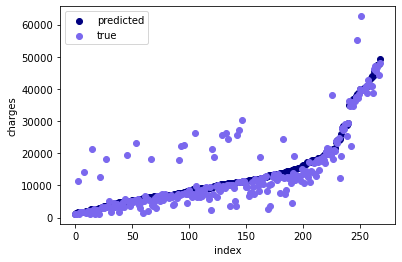

In [ ]:
result_visualization(pred, Y_test)

<BarContainer object of 11 artists>

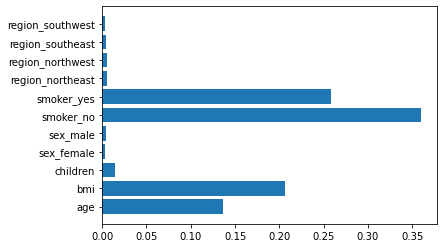

In [ ]:
# plot a graph showing feature importance in the random forest model
plt.barh(X_train.columns, forest_reg.feature_importances_)

Smoker, bmi, age are the three most importance features. Region and sex have little influence on the performance of this model.

# 6. Adaboost regression

In [ ]:
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df = pd.concat([df, pd.get_dummies(df[['sex','smoker','region']])], axis=1)
del df['sex'], df['smoker'], df['region']
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)
X_train = train_set.copy().drop('charges', axis=1)
Y_train = train_set['charges']
X_test = test_set.copy().drop('charges', axis=1)
Y_test = test_set['charges']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada_reg = AdaBoostRegressor()

ada_grid = GridSearchCV(estimator=ada_reg, param_grid={'n_estimators': np.arange(10,200,10)}, cv=5)
ada_grid.fit(X_train, Y_train)
best_param = forest_grid.best_params_['n_estimators']
best_score = forest_grid.best_score_
print(best_param, best_score)

60 0.8493246217456951


In [ ]:
ada_reg = AdaBoostRegressor(n_estimators=best_param, random_state=10)
ada_reg.fit(X_train, Y_train)
pred = ada_reg.predict(X_test)
ada_mse = mean_squared_error(Y_test, pred)
ada_rmse = np.sqrt(ada_mse)
ada_r2 = r2_score(Y_test, pred)
print('ada_rmse=', ada_rmse)
print('ada_r2=', ada_r2)

ada_rmse= 4989.819212443639
ada_r2= 0.8224729276338647


For Adaboost regression, r2=0.822 on test set.

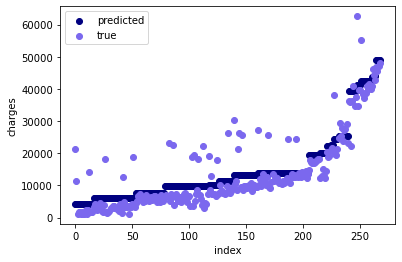

In [ ]:
result_visualization(pred, Y_test)

<BarContainer object of 11 artists>

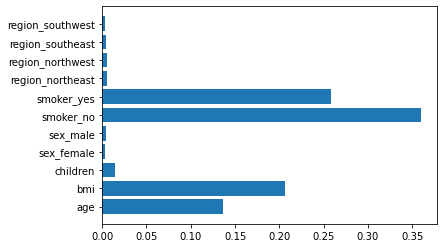

In [ ]:
plt.barh(X_train.columns, forest_reg.feature_importances_)

Overall, we find tree models have better performance on this prediction task, especially for the Adaboost regression.